<a href="https://colab.research.google.com/github/kaburia/NOAA/blob/main/01_Ground_QC_improved_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOAA Workshop – Ground QC Notebook (Improved Trainer Edition)

**How to run:**
1. Go to **Runtime → Restart and run all**.
2. Expect ~10–20 minutes depending on data size and network speed.
3. Look for the green ✅ messages at the end of each step.

> If maps appear blank, go to **File → Trust Notebook**, then rerun.


In [1]:
# === CONFIG (edit here) ======================================================
import os, numpy as np
from datetime import date

# Country / ROI
COUNTRY = 'Kenya'            # 'Kenya' | 'Uganda' | 'Rwanda'
ROI_METHOD = 'OSM'           # 'OSM' (default) or 'GMAPS' if API key available

# Dates
start_date = '2025-04-01'    # ISO format
end_date   = '2025-05-31'

# Output directory (will be created under Google Drive if mounted)
RUN_STAMP = date.today().isoformat()
BASE_OUT = f'/content/drive/MyDrive/NOAA_QC_RUN_{COUNTRY}_{RUN_STAMP}'
os.makedirs(BASE_OUT, exist_ok=True)

# QC thresholds
QC_LIMITS = {
    'rain_min': 0.0,
    'rain_spike_mm': 300.0,    # flag if a single day exceeds this
    'flatline_days': 7,        # flag if >=N days unchanged
}

# Aggregation & matching
CHIRPS_AGG = 'pentad'        # currently pentad-based comparison
MIN_PENTAD_DAYS = 3          # minimum valid daily values to accept a pentad
NEIGHBORHOOD = 3             # 1 (nearest pixel), 3 or 5 for mean of NxN neighborhood

# Scoring weights (must sum to 1.0)
SCORING_WEIGHTS = {
    'corr': 0.35,   # Pearson r (higher is better)
    'rmse': 0.25,   # RMSE (lower is better)
    'bias': 0.15,   # absolute bias (lower is better)
    'complete': 0.20, # pentad completeness (higher is better)
    'outlier': 0.05,  # outlier rate (lower is better)
}

# Confidence definition
High_confidence_threshold = "70"
Low_confidence_threshold = "30"

# Reproducibility
np.random.seed(42)
print('✅ CONFIG set. Outputs will be written to:', BASE_OUT)


✅ CONFIG set. Outputs will be written to: /content/drive/MyDrive/NOAA_QC_RUN_Kenya_2025-10-14


In [2]:
# @title Loading helper functions {"display-mode":"form"}

# @markdown This cell loads helper functions for the Quality control section

# === HELPERS ================================================================
import numpy as np
import pandas as pd

def interquartile_mean(arr):
    """Return the mean of the central 50% (25th–75th percentile)."""
    a = np.sort(np.asarray(arr).astype(float))
    n = len(a)
    if n == 0:
        return np.nan
    lo = int(np.floor(0.25*n))
    hi = int(np.ceil(0.75*n))
    hi = max(hi, lo+1)
    return float(np.mean(a[lo:hi]))

def representative_member(arr):
    """Return value from arr closest to the interquartile mean."""
    iqm = interquartile_mean(arr)
    if np.isnan(iqm):
        return np.nan
    arr = np.asarray(arr).astype(float)
    return float(arr[np.argmin(np.abs(arr - iqm))])

def flag_qc(df, precip_col='precip'):
    """Add simple QC flags to a daily dataframe with a precipitation column."""
    out = df.copy()
    out['neg_rain'] = out[precip_col] < QC_LIMITS['rain_min']
    out['daily_spike'] = out[precip_col] > QC_LIMITS['rain_spike_mm']
    # flatline: same value N days in a row
    runs = (out[precip_col].diff()!=0).cumsum()
    run_lengths = runs.map(runs.value_counts())
    out['flatline_Ndays'] = run_lengths >= QC_LIMITS['flatline_days']
    return out

def qc_summary(df, station_col='station_id', date_col='date', precip_col='precip'):
    """Summarize QC flags per station."""
    grp = df.groupby(station_col)
    summ = grp.agg(
        n_obs=(precip_col, 'size'),
        n_missing=(precip_col, lambda s: int(s.isna().sum())),
        neg_rain=('neg_rain', 'sum'),
        daily_spike=('daily_spike', 'sum'),
        flatline=('flatline_Ndays', 'sum'),
    ).reset_index()
    summ['missing_pct'] = (summ['n_missing'] / summ['n_obs']).round(3)
    return summ

def classify_score(s):
    if s >= 70: return 'High'
    if s >= 50: return 'Medium'
    return 'Low'

print('✅ Helpers loaded')


✅ Helpers loaded


### Station Scoring – Formula (0–100)
We compute per-station metrics on **pentad totals** and convert them to a 0–100 score:

- **corr (r)** – higher is better
- **rmse** (mm/pentad) – lower is better
- **bias** (|gauge − CHIRPS|, mm/pentad) – lower is better
- **complete** – fraction of pentads that meet `MIN_PENTAD_DAYS` – higher is better
- **outlier** – fraction of pentads outside tolerance – lower is better

Weights are set in `SCORING_WEIGHTS` in the Config cell. The final score is:

```
score = 100 * [
  w_corr * norm_corr +
  w_rmse * (1 - norm_rmse) +
  w_bias * (1 - norm_bias) +
  w_complete * complete +
  w_outlier * (1 - outlier)
]
```
with simple min–max normalization of rmse/bias over stations.


# Focus Area 1 — Ground Observations Monitoring &amp; QC
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

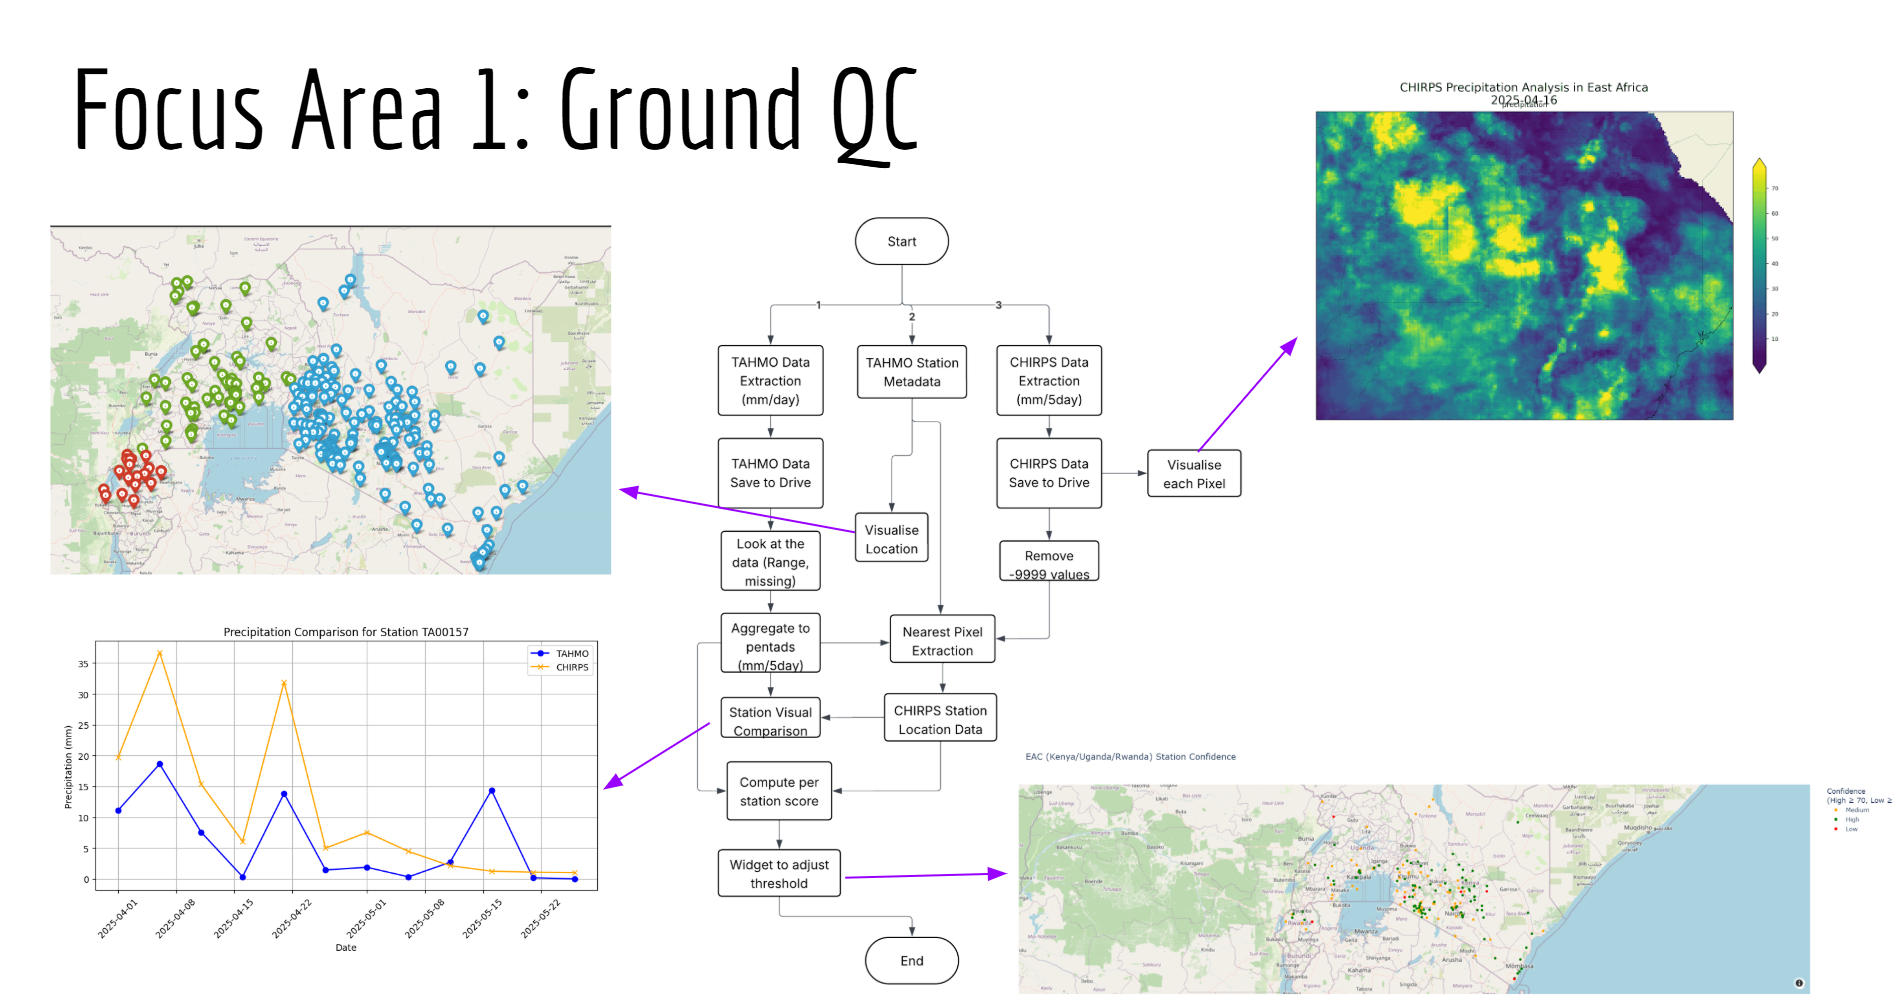

Require 2 files
- The Metadata file: Ground_Metadata.csv
- The Ground_station data file: Ground_data.csv

For TAHMO data we shall extract the data during this workshop period.

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Steps Breakdown
- Step 1: Setting up environment and Authentication

- Data Extraction
    - Step2: Select your region of interest to extract data and perform QC
    - Step3: Filter and visualise the metadata for the region of interest plus the precipitation data extraction
    - Step4: CHIRPS data extraction

- Data Processing and QC

    - Step5: Load the extracted data (Ground + Satellite)
    - Step6: Look at the data (Range, missing)
    - Step7: Aggregate the Ground data to Pentads
    - Step8: Build CHIRPS Nearest data from ground station AND visual comparison
    - Step9: Compute per station score visualising the high/medium/low scores

  
  We suggest running this for 1 particular region then store the results then rerun from step 2 with the different region then do a comparison of the errors on step 10

In [4]:
# @title Step 1a: Setting up environment installing required Dependencies {"display-mode":"form"}
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1
!pip install scipy --upgrade > /dev/null 2>&1 # Added to upgrade scipy

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

Installing required dependencies...
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [5]:
# @title ### Step 1b: Authentication Step {"display-mode":"form"}
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data<br>
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration <br><br>
# @markdown For this workshop, we have created the ```noaa-tahmo``` project that you can input as your project id<br><br><br>

print("Authenticating to Google Drive...")
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive', force_remount=True)
  print("✅ Google Drive authenticated successfully.")
else:
  print("✅ Google Drive already mounted.")

import ee

# Authenticate and initialise Google Earth Engine
# This will open a link in your browser to grant permissions if necessary.
try:
    print("Authenticating Google Earth Engine. Please follow the instructions in your browser.")
    ee.Authenticate()
    print("✅ Authentication successful.")
except ee.auth.scopes.MissingScopeError:
    print("Authentication scopes are missing. Please re-run the cell and grant the necessary permissions.")
except Exception as e:
    print(f"Authentication failed: {e}")

# Initialize Earth Engine with your project ID
# Replace 'your-project-id' with your actual Google Cloud Project ID
# You need to create an unpaid project manually through the Google Cloud Console
print("\nIf you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console")
print("💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id")
try:
    # It's recommended to use a project ID associated with your Earth Engine account.
    print("\nEnter your Google Cloud Project ID: ")
    project_id = input("")
    ee.Initialize(project=project_id)
    print("✅ Google Earth Engine initialized successfully.")
except ee.EEException as e:
    if "PERMISSION_DENIED" in str(e):
        print(f"Earth Engine initialization failed due to PERMISSION_DENIED.")
        print("Please ensure the Earth Engine API is enabled for your project:")
        print("Enable the Earth Engine API here: https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=elated-capsule-471808-k1")
    else:
        print(f"Earth Engine initialization failed: {e}")
except Exception as e:
    print(f"An unexpected error occurred during initialization: {e}")

Authenticating to Google Drive...
✅ Google Drive already mounted.
Authenticating Google Earth Engine. Please follow the instructions in your browser.
✅ Authentication successful.

If you already have a project id paste it below. If you do not have a project You need to create an unpaid project manually through the Google Cloud Console
💡 You can create a new project here: https://console.cloud.google.com/projectcreate and copy the project id

Enter your Google Cloud Project ID: 
noaa-tahmo
✅ Google Earth Engine initialized successfully.


In [6]:
# @title Step 1d: Please upload the provided config file {"display-mode":"form"}
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"✅ File '{file_name}' uploaded successfully.")

# Loading the config file and parsing from uploaded incase it comes with a different name
import json
with open(file_name, 'r') as f:
    config = json.load(f)

Saving config.json to config.json
✅ File 'config.json' uploaded successfully.


## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

We are going to create a Google Drive to be able to export the extracted datasets to this location and we can always load them later<br>

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
    "location_keys": ""

}

```

In [7]:
# @title Step 2: Search and Select Region of Interest {"display-mode":"form"}
# @markdown Enter the name of a country, region, or place in Africa.
# @markdown The Google Maps API will be used to fetch its geometry, bounding box, and show the polygon on a map.


import time
import json
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Polygon
import sys
import importlib

# --- Environment Detection ---
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

IS_COLAB = in_colab()
print(f"💡 Running in {'Google Colab' if IS_COLAB else 'Local Jupyter'} environment.")

try:
    with open('/content/config.json', 'r') as f:
        config = json.load(f)
    location_key = config.get('location_keys', None)
except Exception:
    location_key = None
    print("⚠️ Warning: No API key found. Fallback modes will be used.")

def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region_google(query):
    """Primary: Fetch polygon geometry via Google Maps API"""
    if not location_key:
        raise RuntimeError("Missing Google Maps API key.")
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    return region_geom

def fetch_region_osm(query):
    """Fallback: Fetch geometry from OSM (Nominatim) via GeoPandas"""
    url = f"https://nominatim.openstreetmap.org/search?country={query}&format=geojson&polygon_geojson=1"
    gdf = gpd.read_file(url)
    if gdf.empty:
        raise ValueError("No OSM data found for that query.")
    geom = gdf.iloc[0].geometry
    if geom.geom_type == "Polygon":
        return list(geom.exterior.coords)
    elif geom.geom_type == "MultiPolygon":
        return list(list(geom.geoms)[0].exterior.coords)
    else:
        raise ValueError("Unsupported geometry type from OSM.")

def draw_region_interactively():
    """Manual fallback: let the user draw their ROI"""
    print("🖱️ Draw your region on the map (double-click to finish).")

    if IS_COLAB:
        # ✅ Folium backend (Colab-compatible)
        import geemap.foliumap as geemap
        from geemap.foliumap import plugins

        m = geemap.Map(center=[0, 20], zoom=3)
        draw = plugins.Draw(export=True)
        draw.add_to(m)
        m.add_child(plugins.Fullscreen())
        m.add_child(plugins.MeasureControl(primary_length_unit='kilometers'))
        m  # Display map in Colab output cell

        print("✅ Use the draw tools on the left to mark your region.")
        print("💾 After drawing, click 'Export' to download your GeoJSON.")
        return m

    else:
        # ✅ ipyleaflet backend (Local Jupyter)
        import geemap
        m = geemap.Map(center=[0, 20], zoom=3)
        m.add_draw_control()
        display(m)
        print("✅ After drawing, access your shape via `m.user_rois`.")
        return m


def show_region_plotly(polygon, region_name="Region", margin=0.05):
    """Plot polygon with Plotly Mapbox"""
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    fig = go.Figure(go.Scattermapbox(
        lon=lons + [lons[0]],
        lat=lats + [lats[0]],
        mode="lines",
        fill="toself",
        fillcolor="rgba(0,0,255,0.3)",
        name=region_name
    ))
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(center={"lat": sum(lats)/len(lats), "lon": sum(lons)/len(lons)}, zoom=5),
        margin=dict(r=0, t=30, l=0, b=0),
        title=f"Region of Interest: {region_name}",
        height=500,
        width=900
    )
    fig.show()
    return fig

time.sleep(1) # avoid jumps in the input
region_query = COUNTRY

region_geom = None
try:
    region_geom = fetch_region_google(region_query)
    print(f"✅ Geometry fetched via Google Maps API for {region_query}")
except Exception as e1:
    print(f"⚠️ Google Maps API failed: {e1}")
    try:
        region_geom = fetch_region_osm(region_query)
        print(f"✅ Geometry fetched via OpenStreetMap for {region_query}")
    except Exception as e2:
        print(f"⚠️ OSM fallback failed: {e2}")
        print("🔁 Launching interactive map draw mode...")
        map_widget = draw_region_interactively()

if region_geom:
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    show_region_plotly(region_geom, region_name=region_query)
    print(f"📦 Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
else:
    print("🛑 No geometry available. Please draw manually or retry another query.")

region_query = region_query.lower()


💡 Running in Google Colab environment.
✅ Geometry fetched via Google Maps API for Kenya


📦 Bounding box -> xmin: 33.90982109999999, ymin: -4.724299999999999, xmax: 41.90684160000001, ymax: 5.033420899999999


### Step3: Data Choice

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

Using the method ```get_stations_info()``` to extract the metadata and ```multiple_measurements()``` to extract the precipitation data from multiple stations



In [9]:
# @title Step 3a: Metadata Extraction/Loading and Visualisation
# @markdown At this step we shall also create a directory to start storing the datasets we keep on extracting on Google Drive to easily access and minimize API requests<br>


from utils.filter_stations import RetrieveData
import os
import time

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

# check if the config exists
if not os.path.exists('/content/config.json'):
    print("❌ Config file not found. Please upload it first.")

import plotly.express as px
import pandas as pd

def plot_stations_plotly(dataframes, colors=None, zoom=5, height=500,
                         width=900, legend_title='Station Locations'):
    """
    Plot stations from one or more dataframes on a Plotly mapbox.

    Each dataframe must have 'location.latitude' and 'location.longitude' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    frames = []
    for i, df in enumerate(dataframes):
        temp = df.copy()
        temp["color"] = colors[i % len(colors)]  # cycle colors if more dfs than colors
        frames.append(temp)

    combined = pd.concat(frames, ignore_index=True)

    fig = px.scatter_mapbox(
        combined,
        lat="location.latitude",
        lon="location.longitude",
        color="color",
        hover_name="code",
        zoom=zoom,
        height=height,
        width=width
    )

    fig.update_layout(
        mapbox_style="open-street-map",
        legend_title=legend_title,
        margin={"r": 0, "t": 30, "l": 0, "b": 0}
    )

    return fig



api_key = config['apiKey']
api_secret = config['apiSecret']

# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

# Extracting TAHMO data
print("Extracting TAHMO data...")
info = rd.get_stations_info()
info = info[(info['location.longitude'] >= xmin) &
                        (info['location.longitude'] <= xmax) &
                        (info['location.latitude'] >= ymin) &
                        (info['location.latitude'] <= ymax)]
print("✅ TAHMO data extracted successfully.")
# Print the total number of stations
print(f"Total number of stations: {len(info)}")


# save the data as csv to the created directory
info.to_csv(f'{dir_path}/tahmo_metadata_{region_query}.csv')

# wait for 5 seconds before visual
time.sleep(5)

# Visualise the data
plot_stations_plotly([info], colors=["blue"])

✅ Path created successfully.
Extracting TAHMO data...
✅ TAHMO data extracted successfully.
Total number of stations: 190


In [10]:
# @title Step 3b: Extracting Precipitation data and visualisation
# @markdown Using filter-stations to extract precipitation data <br>

# save to the directory

# print('Extracting Precipitation Data ...')
region_precip = rd.multiple_measurements(stations_list=info['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                         csv_file=f'{dir_path}/tahmo_precip_{region_query}')

# check if the file exist to know if it was successful
if not os.path.exists(f'{dir_path}/tahmo_precip_{region_query}.csv'):
    print("❌ Precipitation data not extracted successfully.")
else:
    print("✅ Precipitation data extracted successfully.")

# Visualise any random station data
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

# plot_stations_data_randomly(region_precip)

region_precip

Retrieving data for stations:   0%|          | 0/190 [00:00<?, ?it/s]

✅ Precipitation data extracted successfully.


,TA00001,TA00018,TA00019,TA00020,TA00021,TA00022,TA00023,TA00024,TA00025_S002904,TA00025_S002905,...,TA00880,TA00884,TA00903_S002979,TA00903_S002980,TA00907,TA00909,TD00001,TD00002,TD00004,TD00005
2025-04-01 00:00:00+00:00,0.000,0.204,0.748,0.051,0.068,NaN,NaN,0.068,NaN,NaN,...,2.058,0.000,NaN,NaN,NaN,NaN,19.77,0.00,0.00,NaN
2025-04-02 00:00:00+00:00,0.068,0.187,0.051,0.017,0.017,NaN,NaN,0.034,NaN,NaN,...,0.000,0.000,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN
2025-04-03 00:00:00+00:00,0.000,0.153,0.000,1.343,0.000,NaN,NaN,0.749,NaN,NaN,...,26.300,0.187,NaN,NaN,NaN,NaN,0.00,1.03,0.53,NaN
2025-04-04 00:00:00+00:00,18.485,0.136,2.839,0.833,8.450,NaN,NaN,6.446,NaN,NaN,...,0.000,0.000,NaN,NaN,NaN,NaN,0.05,0.01,1.65,NaN
2025-04-05 00:00:00+00:00,3.198,0.136,0.595,0.255,0.391,NaN,NaN,0.000,NaN,NaN,...,15.214,11.029,NaN,NaN,NaN,NaN,1.38,7.35,14.30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27 00:00:00+00:00,0.544,4.066,0.289,0.136,7.150,NaN,NaN,NaN,0.000,0.0,...,NaN,0.000,2.844,2.8,NaN,NaN,2.17,NaN,3.70,NaN
2025-05-28 00:00:00+00:00,0.221,5.460,0.187,0.000,0.119,NaN,NaN,NaN,0.000,0.0,...,NaN,0.017,0.500,0.6,NaN,NaN,0.52,NaN,0.66,NaN
2025-05-29 00:00:00+00:00,0.187,3.472,0.102,0.000,0.493,NaN,NaN,NaN,2.365,2.4,...,NaN,0.000,1.000,1.0,NaN,NaN,2.45,NaN,1.00,NaN
2025-05-30 00:00:00+00:00,0.136,10.049,0.034,0.017,1.938,NaN,NaN,0.000,0.000,0.0,...,NaN,0.000,1.900,2.0,NaN,NaN,17.51,NaN,1.92,NaN


In [11]:
# @title ### Step 4: Extracting CHIRPS data

# @markdown Extract the data from Google Earth engine project

# @markdown **Note**: For this workshop, we have done this process for you when we shared the Google Cloud invitation to the project

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(region_geom)

# Extract data for 2020
chirps_ds = get_chirps_pentad_gee(
    start_date=start_date,
    end_date=end_date,
    region=roi,
    export_path=f'{dir_path}/chirps_pentad_{region_query}.nc'
)

# Removing the imputed values resetting to NaN
chirps_ds = chirps_ds.where(chirps_ds != -9999)



Total number of images: 12

Exporting 1/12: chirps_temp/20250401.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250401.tif


Exporting 2/12: chirps_temp/20250406.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250406.tif


Exporting 3/12: chirps_temp/20250411.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250411.tif


Exporting 4/12: chirps_temp/20250416.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250416.tif


Exporting 5/12: chirps_temp/20250421.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250421.tif


Exporting 6/12: chirps_temp/20250426.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250426.tif


Exporting 7/12: chirps_temp/20250501.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250501.tif


Exporting 8/12: chirps_temp/20250506.tif
Generating URL

## Data Processing
1. Looking at the data availability
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

Loading the Extracted TAHMO data and metadata

In [29]:
# @title Step 5: Load the CHIRPS and Ground Precipitation and Metadata
# @markdown This step ensures you can begin from here in the case you lost network or runtime was connected<br>
# @markdown We have been storing the data and you will load this extracted data at this point

# from scipy.stats import pearsonr, ttest_rel
# handle runtime disconnected issues to begin from this step
# 1. check if region query is defined
if not 'region_query' in locals():
    region_query = input("🌍 It seems the runtime was disconnected please enter the region you had selected again: ")
    print('Re-Installing required dependencies ...')
    !pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1
    import xarray as xr
    import time
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    # import ee
    import numpy as np
    # check if config.json file is already available
    if not os.path.exists('/content/config.json'):
      from google.colab import files
      # Upload the TAHMO config file
      print('Please upload the config file provided ...')
      uploaded = files.upload()

    # load the config.json file
    with open('/content/config.json', 'r') as f:
        config = json.load(f)

    location_key = config['location_keys']  # Google Maps API key
    api_key = config['apiKey']
    api_secret = config['apiSecret']


    time.sleep(2)
    # region_query = input("🌍 It seems the runtime was disconnected please write your region you had put againe: ")
    # print(f"Selected: {region_query}")
    # region_query = region_query.lower()

    # re importing the modules


    # import os
    # os.chdir('NOAA-workshop')


    from utils.ground_stations import plot_stations_folium
    from utils.helpers import get_region_geojson
    from utils.CHIRPS_helpers import get_chirps_pentad_gee
    from utils.plotting import plot_xarray_data, plot_xarray_data2
    from utils.filter_stations import RetrieveData

    from google.colab import drive

    def xmin_ymin_xmax_ymax(polygon):
      lons = [pt[0] for pt in polygon]
      lats = [pt[1] for pt in polygon]
      return min(lons), min(lats), max(lons), max(lats)

    def fetch_region(query):
      """Fetch polygon geometry and bounding box for region name"""
      region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
      xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
      print(f"✅ Selected: {query}")
      print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
      return region_geom, (xmin, ymin, xmax, ymax)

    # remounting drive
    drive.mount('/content/drive', force_remount=True)
    # check if the drve folder is available in /content/drive
    if not os.path.exists('/content/drive/MyDrive/NOAA-workshop-data'):
      print("❌ Google Drive not mounted successfully.")
    else:
      print("✅ Google Drive mounted successfully.")

    rd = RetrieveData(api_key,
                    api_secret)

    region_geom, bbox = fetch_region(region_query)

    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)

    dir_path = '/content/drive/MyDrive/NOAA-workshop-data'

    # check if the metadata, chirps and precip data is available
    if not os.path.exists(f'{dir_path}/tahmo_precip_{region_query}.csv'):
      print("❌ Precipitation data not extracted successfully.")
    else:
      print("✅ Precipitation data extracted successfully.")

    if not os.path.exists(f'{dir_path}/tahmo_metadata_{region_query}.csv'):
      print("❌ Metadata not extracted successfully.")
    else:
      print("✅ Metadata extracted successfully.")

    if not os.path.exists(f'{dir_path}/chirps_pentad_{region_query}.nc'):
      print("❌ CHIRPS data not extracted successfully.")
    else:
      print("✅ CHIRPS data extracted successfully.")

import xarray as xr
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
region_precip_data = pd.read_csv(f'{dir_path}/tahmo_precip_{region_query}.csv')
# eac metadata
region_metadata = pd.read_csv(f"{dir_path}/tahmo_metadata_{region_query}.csv")
region_metadata = region_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset(f'{dir_path}/chirps_pentad_{region_query}.nc')
chirps_ds = chirps_ds.where(chirps_ds != -9999)

# Format the TAHMO data
region_precip_data = region_precip_data.rename(columns={"Unnamed: 0": "Date"})
region_precip_data['Date'] = pd.to_datetime(region_precip_data['Date'])
region_precip_data = region_precip_data.set_index('Date')
region_precip_data.index = region_precip_data.index.tz_localize(None)
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data = region_precip_data.drop(columns=multiple_sensors)
# region_precip_data = region_precip_data.dropna(how='all', axis=1)

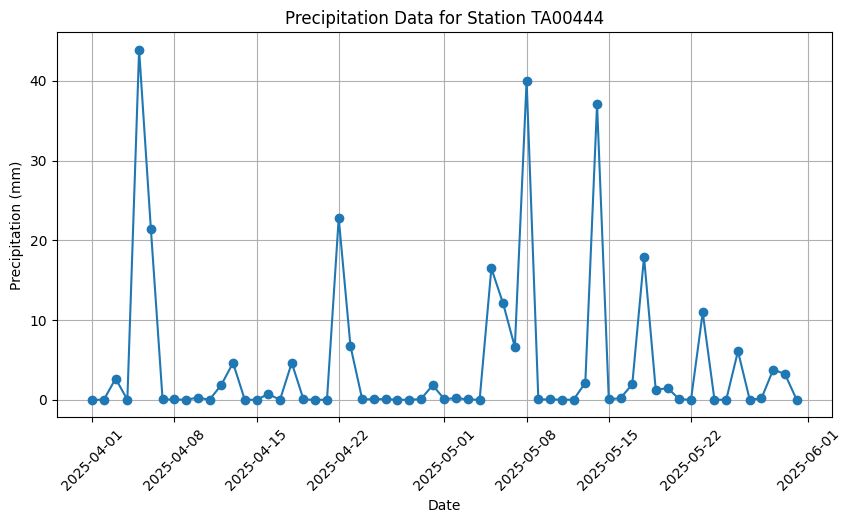

Station Code: TA00444
Data Range: 0.0 mm to 43.896 mm
Number of Records: 61


In [26]:
# @title Step 6a: Check the range of the data and plot any of the stations randomly
# @markdown Rerun to visualise a random station in the region <br>
# @markdown Every single time you run this cell, you will visualise the data for a station for the period you chose
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(region_precip_data)

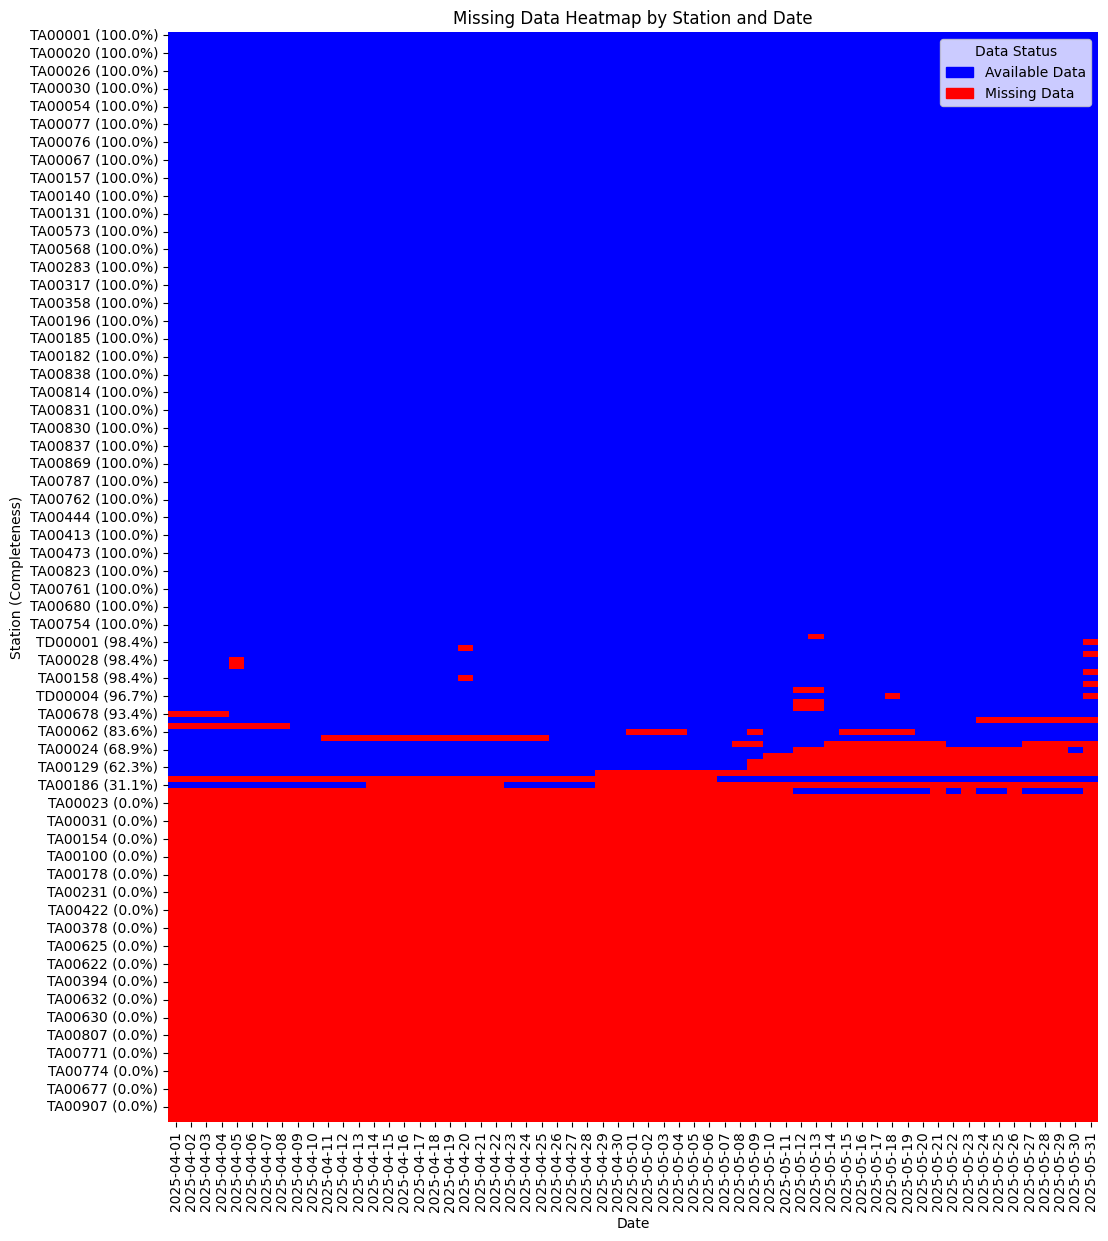

In [30]:
# @title Step 6b: Looking at the data availability for the ground stations {"display-mode":"form"}
# @markdown You will be visualising the number of missing data in your data over time
# Get the stations with missing data
# missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# # print(f"Stations with missing data: {missing_stations}")
# # drop stations with all missing data
# region_precip_data = region_precip_data.dropna(how='all', axis=1)
# region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# # Get the stations with missing data
# missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
# print(f"Stations with missing data: {missing_stations}")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data_filtered = region_precip_data.drop(columns=multiple_sensors)

# Calculate missing data percentage per station over time
missing_data = region_precip_data_filtered.isnull().T
missing_data.columns = list(missing_data.columns.tz_localize(None).astype(str))

# Calculate overall completeness percentage for each station
overall_completeness = (1 - region_precip_data_filtered.isnull().mean(axis=0)) * 100

# Sort stations by overall completeness in descending order
sorted_stations = overall_completeness.sort_values(ascending=False).index
missing_data_sorted = missing_data.loc[sorted_stations]

# Determine the number of stations to dynamically adjust height
num_stations = len(missing_data_sorted)
# Define a base height and an additional height per station
base_height = 5  # Base height in inches
height_per_station = 0.05 # Additional height per station in inches
fig_height = base_height + num_stations * height_per_station

# Create a custom colormap: Blue for non-missing (False), Red for missing (True)
cmap = matplotlib.colors.ListedColormap(['blue', 'red'])

plt.figure(figsize=(12, fig_height))
# Use the custom colormap and specify levels for the two colors, and remove the legend
sns.heatmap(missing_data_sorted, cbar=False, cmap=cmap, vmin=0, vmax=1)

# Create legend patches
blue_patch = mpatches.Patch(color='blue', label='Available Data')
red_patch = mpatches.Patch(color='red', label='Missing Data')

# Add legend to the plot
plt.legend(handles=[blue_patch, red_patch], title="Data Status", loc='upper right')

# Update y-axis labels to include completeness percentage
ax = plt.gca()
y_labels = [f"{label.get_text()} ({overall_completeness.loc[label.get_text()]:.1f}%)" for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels)

plt.title('Missing Data Heatmap by Station and Date')
plt.xlabel('Date')
plt.ylabel('Station (Completeness)')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.show()

In [ ]:
# @title Ground Satellite Map visual comparison
from utils.plotting_point import point_plot

import xarray as xr

# Weather points
html_anim = point_plot(
    region_precip_data.resample('5D').sum().iloc[:-7],
    region_metadata,
    variable_name="Rainfall (mm)", # This is the point data variable name
    metadata_columns=['code', 'lat', 'lon'],
    cmap="plasma",
    grid_da=chirps_ds,
    grid_cmap="coolwarm",
    grid_alpha=0.5,
    fig_title="Station Precipitation vs CHIRPS Background",
    grid_da_var='precipitation'
)

html_anim

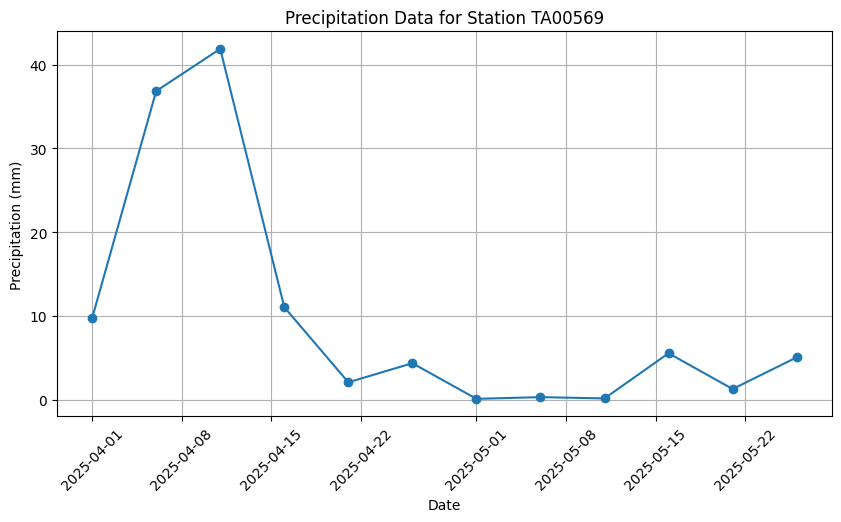

Station Code: TA00569
Data Range: 0.085 mm to 41.9 mm
Number of Records: 12


In [19]:
# @title Step 7: Aggregate station rain to pentads to match CHIRPS.
# @markdown In order to match CHIRPS and how it is extracted we will aggregate the data to pentads (5 days)
region_precip_pentad = rd.aggregate_variables(region_precip_data, freq='5D', method='sum')[:-1]
plot_stations_data_randomly(region_precip_pentad)


In [31]:
# @title Step 8a: Nearest-pixel extraction from CHIRPS and merge with station pentads.
# @markdown At this step we are building the CHIRPS station dataset by using the station metadata (latitude and longitude) to get the nearest value of CHIRPS
# filter to the required stations
req_stations = region_precip_pentad.columns.tolist()

region_metadata = region_metadata[region_metadata['code'].isin(req_stations)]

def build_chirps_from_stations(chirps_ds, stations_metadata):
    import xarray as xr
    import pandas as pd

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Extract nearest pixel data
        station_da = chirps_ds.precipitation.sel(x=lon, y=lat, method="nearest")
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    # Combine all stations into a single DataFrame
    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

chirps_stations = build_chirps_from_stations(chirps_ds, region_metadata)
# plot_stations_data_randomly(chirps_stations)
chirps_stations

,TA00001,TA00018,TA00019,TA00020,TA00021,TA00022,TA00023,TA00024,TA00026,TA00027,...,TA00876,TA00879,TA00880,TA00884,TA00907,TA00909,TD00001,TD00002,TD00004,TD00005
time,,,,,,,,,,,,,,,,,,,,,
2025-04-01,22.675671,21.486406,17.029030,32.880123,11.923936,16.729448,6.539017,26.419672,12.158224,83.109451,...,24.365742,22.266537,20.842934,22.903643,33.998730,22.801519,32.490040,14.299724,17.559780,35.444717
2025-04-06,39.152828,35.857357,34.146309,44.188004,18.160852,24.098034,11.238991,60.622345,24.823616,113.708794,...,55.947163,49.233761,53.034100,37.021641,50.560883,19.186232,55.720226,14.207312,13.635542,64.209160
2025-04-11,55.369488,44.729008,38.641399,21.541342,56.705231,51.498371,9.291699,26.075041,57.467075,39.043400,...,62.184326,57.937565,68.278175,25.679840,30.796175,7.315385,61.982147,48.573303,13.366068,28.006605
2025-04-16,70.299644,85.723030,46.514614,31.004107,45.457085,45.073952,4.877254,30.143660,26.290825,92.270996,...,70.787743,54.278881,62.858532,39.541740,16.714273,16.411409,80.944626,74.819847,8.457671,34.506062
2025-04-21,14.200469,43.154476,23.613579,34.441605,19.487366,29.424362,59.902973,40.287651,30.019978,70.488686,...,17.261326,48.409214,52.206066,37.364731,36.996674,28.632889,46.375072,19.409309,63.178326,58.681835
2025-04-26,29.588150,26.339457,15.584357,16.319296,10.260560,14.939012,4.337674,21.504368,24.265987,15.144296,...,25.291292,33.833702,37.756996,14.719117,13.306293,5.160205,46.071648,13.001306,34.938240,16.256575
2025-05-01,38.841564,49.871922,41.175125,5.011575,33.946831,34.970432,10.460546,14.609083,35.636139,46.308811,...,44.871380,39.284206,40.806782,8.332931,21.924067,11.010787,75.505051,33.666943,62.564739,19.269505
2025-05-06,45.314613,76.498558,81.889191,20.625410,70.281509,98.340042,16.496372,30.026611,37.633018,15.492141,...,48.471680,85.483521,83.038849,32.073853,26.309328,28.859571,92.994568,78.371834,85.519043,43.595974
2025-05-11,60.656330,75.472321,54.697277,40.382950,24.039356,38.479652,12.749688,26.216661,18.308039,3.790132,...,51.872433,87.153610,92.299446,25.524092,25.114698,5.320465,98.628731,26.025696,85.478668,50.518295


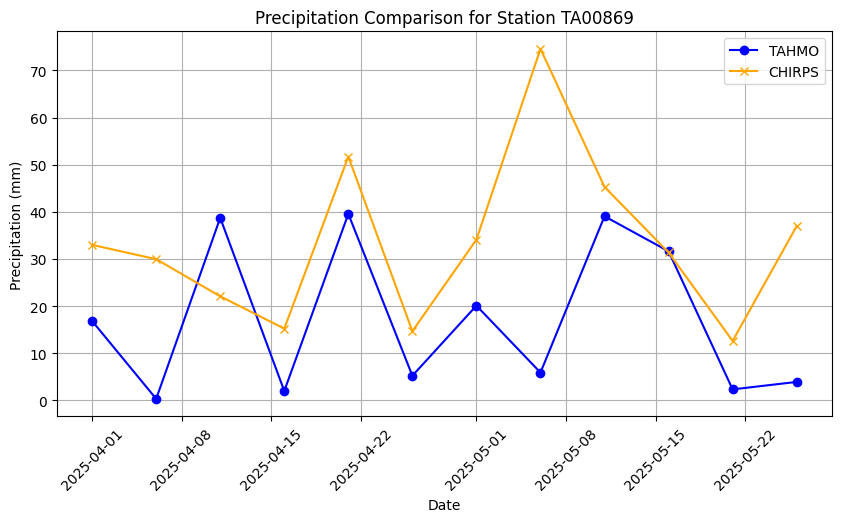

Station Code: TA00869
TAHMO Data Range: 0.32300000000000006 mm to 39.562999999999995 mm
CHIRPS Data Range: 12.61493968963623 mm to 74.58432006835938 mm
Number of TAHMO Records: 12
Number of CHIRPS Records: 12


In [21]:
# @title Step 8b: Plot the CHIRPS data and TAHMO equivalents for a random station
# @markdown Every single time we run this cell we get to visualise the CHIRPS v Ground data comparison for a different station within the region
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations, station_code=None):
    if station_code is None:
      import random
      station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
      if not station_codes:
          print("No common stations between EAC pentad data and CHIRPS data.")
          return

      random_station = random.choice(station_codes)
    else:
      random_station = station_code

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")

plot_chirps_vs_tahmo_randomly(region_precip_pentad, chirps_stations)

In [22]:
# @title Step 9a: Compute Station Scores
# @title Confidence Score Formula
# @markdown ### **Confidence Score Formula**
# @markdown For each station, the confidence score is computed as:
# @markdown
# @markdown $$
# @markdown \text{Confidence Score} = 100 \times \big(0.3 \cdot C \;+\; 0.3 \cdot r \;+\; 0.2 \cdot (1 - O) \;+\; 0.2 \cdot(1- b) \big)
# @markdown $$
# @markdown
# @markdown Where:
# @markdown - $C = 1 -$ (missing fraction of observations), i.e. **completeness**
# @markdown - $r =$ Spearman correlation coefficient between observed and CHIRPS pentads
# @markdown - $O =$ fraction of outliers (observed values < 0)
# @markdown - $b =$ Bias Significance - paired $t$-test between observed and simulated values (significant if $p < 0.05$)
# @markdown
# @markdown ---
# @markdown
# @markdown **Additional metrics per station:**
# @markdown
# @markdown - **RMSE**
# @markdown $$
# @markdown \text{RMSE} = \sqrt{\frac{1}{n} \sum (obs - sim)^2}
# @markdown $$
# @markdown
# @markdown - **Adjusted confidence score**
# @markdown $$
# @markdown \text{Adjusted Confidence Score} = \text{Confidence Score} - \text{RMSE}
# @markdown $$
# @markdown

from scipy.stats import pearsonr, ttest_rel
# spearman correlation
from scipy.stats import spearmanr

def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    if stations.empty:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return None
    # choose only the matching dates by checking the index
    union_dates = eac_pentad.index.intersection(chirps_stations.index)
    # print()
    eac_pentad = eac_pentad.loc[union_dates]
    chirps_stations = chirps_stations.loc[union_dates]
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        corr, _ = spearmanr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        #         confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate)) previous

        confidence_score = 100 * (0.3 * completeness + 0.3 * np.nan_to_num(corr, nan=0) + 0.2 * (1 - outlier_rate)+ 0.2*(1-p_val))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'spearman_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

# @title RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))


station_scores = compute_station_scores(region_precip_pentad, chirps_stations)
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

# save the stations with the confidence scores
station_scores.to_csv(f'{dir_path}/station_scores_{region_query}.csv', index=False)


'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''
station_scores.sort_values(by='confidence_score', ascending=False)


,station_id,confidence_score,spearman_r,rmse,bias_signif,completeness,outlier_rate,adjusted_confidence_score
81,TA00358,97.224826,0.930169,16.067460,Significant,1.000000,0.0,81.157366
163,TA00831,97.007740,0.865462,10.803124,Significant,1.000000,0.0,86.204616
53,TA00172,96.645416,0.864852,25.643137,Significant,1.000000,0.0,71.002280
147,TA00787,94.944070,0.829171,13.739472,Significant,1.000000,0.0,81.204598
36,TA00108,94.478670,0.870163,24.647963,Significant,1.000000,0.0,69.830706
...,...,...,...,...,...,...,...,...
175,TA00880,NaN,NaN,35.207061,Not Significant,0.916667,0.0,NaN
177,TA00907,NaN,NaN,NaN,Not Significant,0.000000,0.0,NaN
178,TA00909,NaN,NaN,NaN,Not Significant,0.000000,0.0,NaN
180,TD00002,NaN,NaN,24.632113,Not Significant,0.916667,0.0,NaN


In [ ]:
# @title Step 9b: Export to Excel the confidence scores
from google.colab import files
print('Exporting station scores to Excel ...')
station_scores.to_excel(f'{dir_path}/station_scores_{region_query}.xlsx', index=False)
files.download(f'{dir_path}/station_scores_{region_query}.xlsx')

# print('✅ Su')

Exporting station scores to Excel ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Step 9c:Setting the threshold for high and low

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc",
    width=900, # Add width parameter
    height=600 # Add height parameter
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    # Added 'spearman_r' to the list of columns to merge
    merge_cols = ['station_id','confidence_score','class','spearman_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'spearman_r': ':.3f', # Ensure this is correctly referenced
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'},
        width=width, # Pass width to scatter plot
        height=height # Pass height to scatter plot
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

        # -------- 6. Geo Map (with categories, OSM basemap) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_mapbox(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'spearman_r': ':.3f', # Ensure this is correctly referenced
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence",
        zoom=5,
        height=height,
        width=width
    )
    # map_fig.update_layout(
    #     legend_title_text='Confidence',
    #     mapbox_style="open-street-map"
    # )
    map_fig.update_layout(
        mapbox_style="open-street-map",
        legend_title_text=f"Confidence<br>(High ≥ {high_thr}, Low < {low_thr})"
    )

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        lat_center = (lat_min + lat_max) / 2
        lon_center = (lon_min + lon_max) / 2
        map_fig.update_layout(
            mapbox_center={"lat": lat_center, "lon": lon_center},
            mapbox_zoom=5
        )


    return m_long, score_map, scatter_fig, map_fig

# Get the user to input the high and low threshold
time.sleep(1)
high_thr = int(High_confidence_threshold)
low_thr = int(Low_confidence_threshold)

print(f"High threshold: {high_thr}")
print(f"Low threshold: {low_thr}")
import time
time.sleep(2)

m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    region_precip_pentad,
    chirps_stations,
    station_scores,
    region_metadata,
    country_label=f"{region_query}",
    high_thr=high_thr,
    low_thr=low_thr,
    scatter_color="#3366cc",
    width=900, # Pass width to the function call
    height=600 # Pass height to the function call
)

if scatter_fig is not None:
    scatter_fig.show()
if map_fig is not None: # Also check if map_fig is not None before showing
    map_fig.show()

High threshold: 70
Low threshold: 30


In [ ]:
# @title Step 10


In [23]:
# === OUTPUT BUNDLER =========================================================

'''
comments from Cynthia, delete after impelmentation. this cell is to save differen files,
where these files are created ensure it is stored with same names. for example the figues
are already created so just a matter of saving in the correct names. E.g the station scores
in previous step store as scores_bar.png

'''
import os, shutil
files_to_copy = []
candidates = [
    'ground_pentads.csv','chirps_pentads.csv','merged_station_pentads.csv',
    'qc_flags.csv','qc_summary.csv','station_scores.csv',
    'random_station_plot.png','scores_bar.png'
]
for fn in candidates:
    if os.path.exists(fn):
        files_to_copy.append(fn)

for fn in files_to_copy:
    shutil.copy(fn, os.path.join(BASE_OUT, fn))

print(f'✅ Saved {len(files_to_copy)} outputs to: {BASE_OUT}')


✅ Saved 0 outputs to: /content/drive/MyDrive/NOAA_QC_RUN_Kenya_2025-10-14


In [37]:
# === CHIRPS neighborhood helpers (xarray) ===================================
import numpy as np
try:
    import xarray as xr
except Exception as e:
    xr = None
    print('ℹ️ xarray not available; CHIRPS neighborhood functions will be skipped.')

def neighborhood_mean(da, lat, lon, k=NEIGHBORHOOD):
    """
    Return CHIRPS value at (lat, lon) using either nearest pixel (k=1) or
    mean of k x k neighbors around nearest index when k=3 or 5.
    Assumes DataArray with dims (..., 'y', 'x').
    """
    if xr is None:
        return np.nan
    # find nearest index using 'y' and 'x' dimensions
    i_lat = int(da.y.to_index().get_indexer([lat], method='nearest')[0])
    i_lon = int(da.x.to_index().get_indexer([lon], method='nearest')[0])
    if k == 1:
        return da.isel(y=i_lat, x=i_lon)
    # compute window bounds using 'y' and 'x' dimensions
    r = k//2
    sl = da.isel(y=slice(max(i_lat-r,0), i_lat+r+1), x=slice(max(i_lon-r,0), i_lon+r+1))
    return sl.mean(dim=('y','x'), skipna=True)

print('✅ CHIRPS neighborhood helpers ready (NEIGHBORHOOD =', NEIGHBORHOOD, ')')

✅ CHIRPS neighborhood helpers ready (NEIGHBORHOOD = 3 )


In [43]:
# === Build CHIRPS DataFrame using neighborhood_mean ===
import pandas as pd

# Ensure required data is available
if 'chirps_ds' not in globals():
    print('⚠️ CHIRPS xarray dataset (chirps_ds) not found.')
elif 'region_metadata' not in globals():
    print('⚠️ Region metadata dataframe (region_metadata) not found.')
elif 'neighborhood_mean' not in globals():
    print('⚠️ neighborhood_mean function not found. Please run the "CHIRPS neighborhood helpers" cell.')
else:
    chirps_neighborhood_stations = {}
    for index, row in region_metadata.iterrows():
        station_id = row['code']
        lat = row['lat']
        lon = row['lon']

        # Use the neighborhood_mean function to extract CHIRPS data
        station_chirps_da = neighborhood_mean(chirps_ds.precipitation, lat=lat, lon=lon, k=NEIGHBORHOOD)

        # Convert to DataFrame and store
        chirps_neighborhood_stations[station_id] = station_chirps_da.to_dataframe(name=station_id)[station_id]

    # Combine all stations into a single DataFrame
    chirps_neighborhood_df = pd.DataFrame(chirps_neighborhood_stations)

    print(f'✅ Built CHIRPS neighborhood DataFrame for {len(chirps_neighborhood_df.columns)} stations using a {NEIGHBORHOOD}x{NEIGHBORHOOD} neighborhood.')
    display(chirps_neighborhood_df.head())

# === Reshape CHIRPS neighborhood DataFrame ===
if 'chirps_neighborhood_df' not in globals():
    print('⚠️ CHIRPS neighborhood DataFrame (chirps_neighborhood_df) not found.')
else:
    # Reset the index to make 'time' a column and rename it to 'pentad_start'
    chirps_neighborhood_df_reset = chirps_neighborhood_df.reset_index().rename(columns={'time': 'pentad_start'})

    # Melt the DataFrame to have station_id and chirps_pentad columns
    chirps_neighborhood_melted = chirps_neighborhood_df_reset.melt(
        id_vars='pentad_start',
        var_name='station_id',
        value_name='chirps_pentad'
    )

    # Display the first few rows of the melted DataFrame
    print('✅ Reshaped CHIRPS neighborhood DataFrame.')
    display(chirps_neighborhood_melted.head())

    # Assign the melted DataFrame back to a variable for later use (e.g., merging)
    chirps_neighborhood_pentad = chirps_neighborhood_melted

✅ Built CHIRPS neighborhood DataFrame for 183 stations using a 3x3 neighborhood.


,TA00001,TA00018,TA00019,TA00020,TA00021,TA00022,TA00023,TA00024,TA00026,TA00027,...,TA00876,TA00879,TA00880,TA00884,TA00907,TA00909,TD00001,TD00002,TD00004,TD00005
time,,,,,,,,,,,,,,,,,,,,,
2025-04-01,22.783388,21.079166,20.209646,29.562984,12.179555,15.757189,9.274137,27.217079,13.575123,86.784042,...,23.832661,22.702263,23.146431,24.704247,33.504757,22.853876,32.730545,17.087929,25.851976,34.778088
2025-04-06,40.224129,34.959885,34.034897,44.310169,18.700209,22.823006,11.850391,65.545929,29.865417,111.840958,...,54.079697,49.254677,51.485744,34.743515,46.696163,22.516306,53.756348,15.331492,15.825248,59.567104
2025-04-11,56.228596,47.413330,42.745701,21.944178,55.836010,49.927891,10.860373,26.403038,60.123699,37.571953,...,63.375393,61.343349,66.415771,23.792818,29.872959,7.632011,59.075764,52.641598,15.742270,28.788269
2025-04-16,66.159454,83.361359,45.783890,31.447798,45.613361,42.849079,5.143073,29.491219,29.229815,96.011124,...,73.803253,62.759197,64.734779,37.540646,16.796566,17.575348,77.544724,79.579269,9.850101,32.616257
2025-04-21,13.416791,41.760216,25.846519,33.139702,20.889301,29.640133,52.226852,42.899345,32.765018,78.961136,...,16.764978,50.499954,50.665867,34.953644,37.748962,33.383007,46.494396,25.208126,72.268257,59.520081


✅ Reshaped CHIRPS neighborhood DataFrame.


,pentad_start,station_id,chirps_pentad
0,2025-04-01,TA00001,22.783388
1,2025-04-06,TA00001,40.224129
2,2025-04-11,TA00001,56.228596
3,2025-04-16,TA00001,66.159454
4,2025-04-21,TA00001,13.416791


In [33]:
# === Pentad aggregation with completeness + QC exports ======================

# === Pentad aggregation with completeness + QC exports ======================
import pandas as pd
import os


df_daily = region_precip_data.copy()
# Expect a daily dataframe `df_daily`
if 'df_daily' not in globals():
    print('⚠️ df_daily not found. Please ensure your ground daily dataframe is in memory as df_daily.')
else:
    # Melt the dataframe to have station_id as a column
    dfd = df_daily.copy().reset_index().melt(id_vars='Date', var_name='station_id', value_name='precip')
    dfd = dfd.rename(columns={'Date': 'date'})
    dfd['date'] = pd.to_datetime(dfd['date'])
    dfd = dfd.sort_values(['station_id','date'])

    # QC flags on daily
    dfd = flag_qc(dfd, precip_col='precip')
    # Exports: qc_flags and summary
    qc_summ = qc_summary(dfd)
    qc_summ.to_csv('qc_summary.csv', index=False)
    dfd.to_csv('qc_flags.csv', index=False)

    # Pentad label using 5D anchored periods starting from month start
    dfd['pentad_start'] = dfd['date'].dt.to_period('5D').dt.start_time

    def agg_pentad(g):
        # accept pentad if at least MIN_PENTAD_DAYS valid (non-NA) days
        valid = g['precip'].notna().sum()
        total = g['precip'].sum(min_count=1)
        status = 'complete' if valid >= MIN_PENTAD_DAYS else 'skip'
        return pd.Series({'precip_pentad': total, 'valid_days': valid, 'status': status})

    pent = (dfd.groupby(['station_id','pentad_start'])
              .apply(agg_pentad)
              .reset_index())

    # keep only complete pentads
    pent_keep = pent[pent['status'] != 'skip'].copy()
    pent_keep.to_csv('ground_pentads.csv', index=False)
    print('✅ Pentad aggregation complete:', len(pent_keep), 'rows saved to ground_pentads.csv')
    print('✅ QC exports saved: qc_flags.csv, qc_summary.csv')

    # ensure outputs folder
    os.makedirs(BASE_OUT, exist_ok=True)
    for fn in ['ground_pentads.csv','qc_flags.csv','qc_summary.csv']:
        if os.path.exists(fn):
            os.system(f'cp {fn} "{BASE_OUT}/{fn}"')
    print('✅ Copied to', BASE_OUT)


✅ Pentad aggregation complete: 0 rows saved to ground_pentads.csv
✅ QC exports saved: qc_flags.csv, qc_summary.csv
✅ Copied to /content/drive/MyDrive/NOAA_QC_RUN_Kenya_2025-10-14


In [34]:
# === Interactive station viewer (ipywidgets) ================================
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
try:
    import ipywidgets as widgets
except Exception as e:
    widgets = None

if widgets is None or 'dfd' not in globals(): # Use dfd instead of df_daily
    print('ℹ️ ipywidgets or dfd not available; skipping interactive viewer.')
else:
    dfdv = dfd.copy() # Use dfd
    dfdv['date'] = pd.to_datetime(dfdv['date']) # Ensure 'date' is datetime
    stations = sorted(dfdv['station_id'].dropna().unique().tolist())
    dd = widgets.Dropdown(options=stations, description='Station:', value=stations[0] if stations else None)
    out = widgets.Output()

    def plot_station(station):
        with out:
            out.clear_output()
            dfp = dfdv[dfdv['station_id']==station].sort_values('date')
            if 'neg_rain' not in dfp.columns:
                dfp = flag_qc(dfp)
            fig, ax = plt.subplots(figsize=(10,3))
            ax.plot(dfp['date'], dfp['precip'], marker='o', lw=1)
            # highlight flagged
            bad = dfp['neg_rain'] | dfp['daily_spike'] | dfp['flatline_Ndays']
            ax.scatter(dfp.loc[bad,'date'], dfp.loc[bad,'precip'], s=30)
            ax.set_title(f'Precip daily: {station}')
            ax.set_xlabel('Date'); ax.set_ylabel('mm')
            fig.tight_layout()
            fig.savefig('random_station_plot.png')
            plt.show()

    if stations: # Check if stations list is not empty before plotting
        plot_station(dd.value)
        display(dd, out)
        dd.observe(lambda ch: plot_station(ch['new']), names='value')
        print('✅ Interactive station viewer ready. PNG saved as random_station_plot.png when refreshed.')
    else:
        print('No stations available to display.')

Dropdown(description='Station:', options=('TA00001', 'TA00018', 'TA00019', 'TA00020', 'TA00021', 'TA00022', 'T…

Output()

✅ Interactive station viewer ready. PNG saved as random_station_plot.png when refreshed.


Correlation comparison (first 10 stations):


,station_id,corr_pearson,corr_spearman,corr
0,TA00001,-0.217987,0.094571,-0.217987
1,TA00018,0.019213,0.245184,0.019213
2,TA00019,-0.048360,0.130749,-0.048360
3,TA00020,0.377575,0.678483,0.377575
4,TA00021,0.588483,0.511384,0.588483
5,TA00024,0.774269,0.108788,0.774269
6,TA00026,0.212972,-0.077467,0.212972
7,TA00028,-0.183388,-0.292391,-0.183388
8,TA00029,0.151572,0.273205,0.151572
9,TA00030,-0.056162,-0.042789,-0.056162


ℹ️ CORR_METHOD used in scoring: pearson
✅ Scoring complete. station_scores.csv & scores_bar.png saved.
✅ Copied to /content/drive/MyDrive/NOAA_QC_RUN_Kenya_2025-10-14


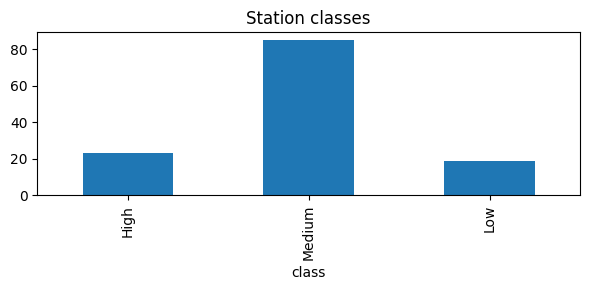

In [42]:
# === Scoring (0–100) and exports ===========================================
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
from IPython.display import display

# Toggle correlation used in final score: 'pearson' or 'spearman'
CORR_METHOD = 'pearson'   # <-- change to 'spearman' during training to compare

# Expect a merged pentads dataframe with columns:
# ['station_id','pentad_start','precip_pentad','chirps_pentad']

# merge the chirps pentad and station pentads
merged = pd.merge(pent, chirps_neighborhood_pentad, on=['station_id','pentad_start'], how='left')
if 'merged' not in globals():
    # If not in memory, try to load a saved merge
    if os.path.exists('merged_station_pentads.csv'):
        merged = pd.read_csv('merged_station_pentads.csv', parse_dates=['pentad_start'])
        print('ℹ️ Loaded merged from merged_station_pentads.csv')
    else:
        print('⚠️ merged pentad dataframe not found. Provide DataFrame "merged" or file merged_station_pentads.csv.')

if 'merged' in globals():
    m = merged.dropna(subset=['precip_pentad','chirps_pentad']).copy()

    rows = []
    for sid, g in m.groupby('station_id'):
        if len(g) < 3:
            continue

        # Compute both Pearson and Spearman (for illustration)
        corr_pearson  = g[['precip_pentad','chirps_pentad']].corr(method='pearson').iloc[0,1]
        corr_spearman = g[['precip_pentad','chirps_pentad']].corr(method='spearman').iloc[0,1]
        corr = corr_pearson if CORR_METHOD == 'pearson' else corr_spearman

        rmse = np.sqrt(((g['precip_pentad']-g['chirps_pentad'])**2).mean())
        bias = (g['precip_pentad']-g['chirps_pentad']).abs().mean()
        complete = 1.0  # replace with pentad completeness if tracked per station
        # outlier rate: outside ±2 std of diff
        diff = g['precip_pentad']-g['chirps_pentad']
        thr = 2*diff.std(ddof=1) if diff.std(ddof=1)>0 else float('inf')
        outlier = float((diff.abs() > thr).mean())

        rows.append([sid, corr, corr_pearson, corr_spearman, rmse, bias, complete, outlier])

    sc = pd.DataFrame(rows, columns=[
        'station_id','corr','corr_pearson','corr_spearman','rmse','bias','complete','outlier'
    ])

    # normalization (min–max) for rmse/bias (protect zero-range)
    def minmax(x):
        mn, mx = x.min(), x.max()
        if np.isclose(mx-mn, 0):
            return np.ones_like(x)
        return (x - mn) / (mx - mn)

    norm_corr = sc['corr'].clip(lower=0).fillna(0)
    norm_rmse = minmax(sc['rmse'])
    norm_bias = minmax(sc['bias'])
    complete  = sc['complete'].clip(0,1).fillna(0)
    outlier   = sc['outlier'].clip(0,1).fillna(0)

    # SCORING_WEIGHTS must already exist in the notebook config
    w = SCORING_WEIGHTS
    score = 100*(w['corr']*norm_corr
                 + w['rmse']*(1-norm_rmse)
                 + w['bias']*(1-norm_bias)
                 + w['complete']*complete
                 + w['outlier']*(1-outlier))
    sc['score'] = score.round(1)
    sc['class'] = sc['score'].apply(classify_score)
    sc.to_csv('station_scores.csv', index=False)

    # Side-by-side correlation table for training illustration
    print('Correlation comparison (first 10 stations):')
    display(sc[['station_id','corr_pearson','corr_spearman','corr']].head(10))
    print(f'ℹ️ CORR_METHOD used in scoring: {CORR_METHOD}')

    # Bar chart of classes
    fig, ax = plt.subplots(figsize=(6,3))
    sc['class'].value_counts().reindex(['High','Medium','Low']).plot.bar(ax=ax)
    ax.set_title('Station classes')
    fig.tight_layout(); fig.savefig('scores_bar.png')
    print('✅ Scoring complete. station_scores.csv & scores_bar.png saved.')

    # Copy to Drive (if BASE_OUT configured)
    try:
        os.makedirs(BASE_OUT, exist_ok=True)
        for fn in ['station_scores.csv','scores_bar.png']:
            if os.path.exists(fn):
                os.system(f'cp {fn} "{BASE_OUT}/{fn}"')
        print('✅ Copied to', BASE_OUT)
    except Exception as e:
        pass
